In [2]:
import numpy as np
from typing import Tuple, Optional, Union

import matplotlib.pyplot as plt

from mlp import DenseLayer, MLP
from ops import ReLU, MeanSquaredError

np.random.seed(0)

In [6]:
x = np.arange(1, 5)
print(x)
print(np.dot(x, x))

lst = []
for ele in x:
    lst.append(ele * ele)

print(sum(lst))

[1 2 3 4]
30
30


In [ ]:
# (W^{l+1}_jk)^T DOT d_^{l+1}j HADAMARD phi(z_j)
# C_k1 HADAMARD 
# j = num_neurons_in_cur_layer = 2
# k = num_neurons_in_prev_layer = 3
# o         o     
#           o          o
# o         o 
#       j=3, k=2    j=1, k=3
# (W^{l+1}_13)^T DOT d^{l+1}_1 H phi(z_3)
# W^{l+1}_31 DOT d^{l+1}_1 H phi(z_3)
# C_3 H Phi(z_3)

In [3]:
a = np.random.normal(size=(32, 1))
b = np.random.normal(size=(32, 1))
c = np.random.normal(size=(32,))

print(np.atleast_2d(c).shape)

print(np.transpose(a).shape)
print(np.transpose(c).shape)

(1, 32)
(1, 32)
(32,)


In [5]:
x = np.arange(0, 5)
y = np.full_like(x, fill_value=2)

print(x)
print('hadamard', x * y)
print(np.dot(x, y))

[0 1 2 3 4]
hadamard [0 2 4 6 8]
20


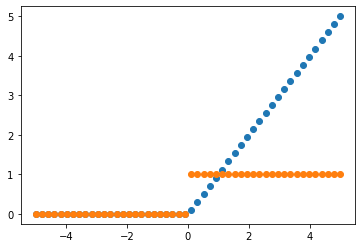

In [7]:
x = np.linspace(-5, 5)
y = ReLU()(x)
dydx = ReLU().derivative(x)
plt.scatter(x, y)
plt.scatter(x, dydx)

In [8]:
# Input data
rows = 5
cols = 10
input_vector = np.random.normal(size=(rows, cols))
dummy_pred_vector = np.random.normal(size=(rows, cols))

In [9]:
# Instantiate Layer
lyr = DenseLayer(input_dims=input_vector.shape[-1], num_units=2)

In [10]:
# Layer call
lyr_activations, lyr_wt_inputs = lyr(input_vector)
print('input:', input_vector.shape)
print('output:', lyr_activations.shape, lyr_wt_inputs.shape)
print(lyr_activations, '\n\n', lyr_wt_inputs)

input: (5, 10)
output: (5, 2) (5, 2)
[[-0.42647349 -0.24779502]
 [-0.28689659 -0.40105034]
 [-0.32231351 -0.45992227]
 [-0.18448811  0.24800787]
 [ 0.17294692  0.21348298]] 

 [[-0.42647349 -0.24779502]
 [-0.28689659 -0.40105034]
 [-0.32231351 -0.45992227]
 [-0.18448811  0.24800787]
 [ 0.17294692  0.21348298]]


In [13]:
model = MLP(input_dims=input_vector.shape[-1], hidden_units=2, targets=1, loss_function=mse, learning_rate=1e-3, l_layers=2)

([], [])

In [20]:
# Result of forward pass
fwd = model._forward_pass(inputs=input_vector)
print(fwd)
print(fwd.shape)

[[ 0.13224191]
 [ 0.01783743]
 [-0.16562248]
 [-0.15245786]
 [-0.05169993]]
(5, 1)


In [ ]:
batch_size = 32
samples = 100
y_batch_indices = np.random.choice(
            a=samples, size=(samples//batch_size, batch_size), replace=False) 

3
[[22 51 90 17 94 76 89 87  8 53 98 55 50 31 26 28 88 79 34 74 39 85 12 16
  83 64 20 67 58 77 25  7]
 [86 36 21 72 84 57  9 11 96 82 68 49  5 14 15 37 19 33 69 78 59 56  4 91
  75  6 95 44 65 62 29 40]
 [71 24 81 41 73 45 13 23 42 52 92 38 63 60  2 46 70 93 32  3  0 80 97 99
   1 30 48 27 47 43 18 10]]
